In [6]:
import pandas as pd
import requests
from tqdm import tqdm
import time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import matplotlib.pyplot as plt

movies = pd.read_csv('C:/Users/jonab/.vscode/PROJECTS/Web Development Projects/Movie Recommendation Application/data_science/datasets/raw/movies.dat',
    sep="::",
    engine='python', # needed bcs of double colon separator
    header=None,
    names=[
       'movie_id', 'title', 'genres'
    ],
    encoding='latin-1'
)

# FOR movies table: extract release year and get the clean title itself.
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(int)
movies['clean_title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

print(movies.head())

session = requests.Session()

retry = Retry(
    total=5,
    backoff_factor=1,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"],
)

adapter = HTTPAdapter(max_retries=retry)
session.mount("https://", adapter)

   movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

   release_year                  clean_title  
0          1995                    Toy Story  
1          1995                      Jumanji  
2          1995             Grumpier Old Men  
3          1995            Waiting to Exhale  
4          1995  Father of the Bride Part II  


In [7]:
TMDB_API_KEY = "0db2ba32a7e681572ff594c6ae053424"

# Helper function: gets the poster url and overview for a movie, marked by its title and year
def fetch_tmdb_movie(title, year=None):
    uri = 'https://api.themoviedb.org/3/search/movie'
    params = {
        'api_key' : TMDB_API_KEY,
        'query' : title,
        'year' : year,
    }
    response = requests.get(uri, params=params)
    data = response.json()

    time.sleep(0.25)
    
    if data['results']:
        movie = data['results'][0] # take the top match
        overview = movie.get('overview', '')
        poster_path = movie.get('poster_path', '')
        poster_url = f"https://image.tmdb.org/t/p/w500{poster_path}" if poster_path else ''
        return overview, poster_url
    return '',''

overviews = []
poster_urls = []

for _, row in tqdm(movies.iterrows(), total=len(movies)):
    overview, poster_url = fetch_tmdb_movie(row['clean_title'], row['release_year'])
    overviews.append(overview)
    poster_urls.append(poster_url)

movies['overview'] = overviews
movies['poster_url'] = poster_urls

100%|██████████| 3883/3883 [1:51:38<00:00,  1.73s/it]


In [8]:
ratings = pd.read_csv(
    'C:/Users/jonab/.vscode/PROJECTS/Web Development Projects/Movie Recommendation Application/data_science/datasets/raw/ratings.dat',
    sep='::',
    engine='python',
    header=None,
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

print(ratings.head())

   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [9]:
# Only run this part if you want to see metrics of the data

print(f"Number of movies: {movies['movie_id'].nunique()}")
print(f"Number of users: {ratings['user_id'].nunique()}")

# # plot rating distribution
# ratings['rating'].hist(bins=5, figsize=(6, 4))
# plt.xlabel('Ratings')
# plt.ylabel('Count')
# plt.title('Rating Distribution')
# plt.show()

# get average rating per movie
avg_ratings = ratings.groupby('movie_id')['rating'].mean()

movies = movies.merge(
    avg_ratings.rename('rating_avg'),
    on='movie_id',
    how='left'
)

print(avg_ratings.head())

Number of movies: 3883
Number of users: 6040
movie_id
1    4.146846
2    3.201141
3    3.016736
4    2.729412
5    3.006757
Name: rating, dtype: float64


   Action  Adventure  Animation  Children's  Comedy  Crime  Documentary  \
0       0          0          1           1       1      0            0   
1       0          1          0           1       0      0            0   
2       0          0          0           0       1      0            0   
3       0          0          0           0       1      0            0   
4       0          0          0           0       1      0            0   

   Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
0      0        0          0       0        0        0        0       0   
1      0        1          0       0        0        0        0       0   
2      0        0          0       0        0        0        1       0   
3      1        0          0       0        0        0        0       0   
4      0        0          0       0        0        0        0       0   

   Thriller  War  Western  
0         0    0        0  
1         0    0        0  
2         0   

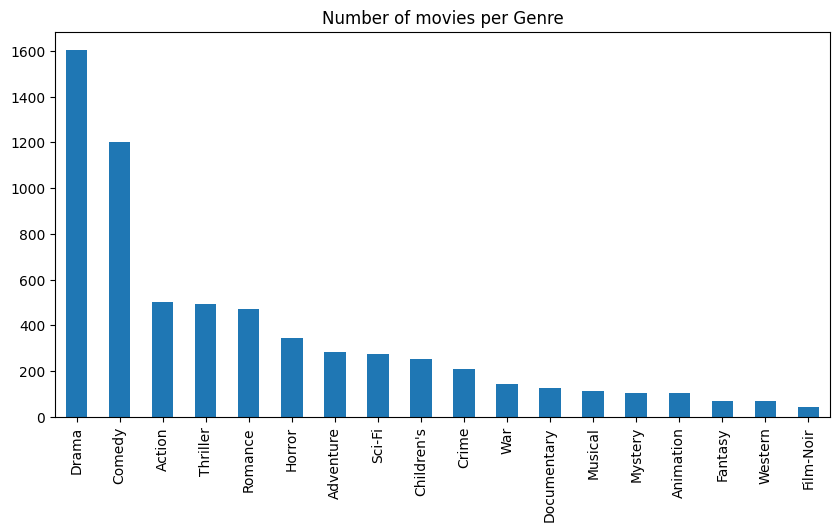

In [10]:
# Each column has its own genre.
# Each cell is 1 if the movie belongs to that genre, and 0 otherwise.
genres_expanded = movies['genres'].str.get_dummies('|')
print(genres_expanded.head())


# .sum() will add up all the 1s in each column which will yeild the number of movies per genre.
# Then these genres will be sorted in descending order from most to least common.
genres_counts = genres_expanded.sum().sort_values(ascending=False)

# We create a bar chart that will illustrate to us the 5 genres and their popularity.
# X-axis: genre name
# Y-axis: number of movies in that genre
genres_counts.plot(kind='bar', figsize=(10, 5), title="Number of movies per Genre")
plt.show()

In [11]:
data = ratings.merge(movies, on='movie_id')
print(data.head())

movies_cleaned = movies.join(genres_expanded)

movies_cleaned.to_csv('C:/Users/jonab/.vscode/PROJECTS/Web Development Projects/Movie Recommendation Application/data_science/datasets/processed/movies_clean_again.csv', index=False)

# # Save rating
# ratings.to_csv('C:/Users/jonab/.vscode/PROJECTS/Web Development Projects/Movie Recommendation Application/data_science/datasets/processed/ratings_cleaned.csv', index=False)

# # save merged movies/ratings
# data.to_csv('C:/Users/jonab/.vscode/PROJECTS/Web Development Projects/Movie Recommendation Application/data_science/datasets/processed/ratings_movies_cleaned.csv', index=False)


   user_id  movie_id  rating  timestamp  \
0        1      1193       5  978300760   
1        1       661       3  978302109   
2        1       914       3  978301968   
3        1      3408       4  978300275   
4        1      2355       5  978824291   

                                    title                        genres  \
0  One Flew Over the Cuckoo's Nest (1975)                         Drama   
1        James and the Giant Peach (1996)  Animation|Children's|Musical   
2                     My Fair Lady (1964)               Musical|Romance   
3                  Erin Brockovich (2000)                         Drama   
4                    Bug's Life, A (1998)   Animation|Children's|Comedy   

   release_year                      clean_title  \
0          1975  One Flew Over the Cuckoo's Nest   
1          1996        James and the Giant Peach   
2          1964                     My Fair Lady   
3          2000                  Erin Brockovich   
4          1998               